In [1]:
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

from tqdm import tqdm
from mobilenetv3 import MobileNetV3_Small
from mobilenetv3 import MobileNetV3_Large
from mobilenetv2 import MobileNetV2
from mobilenetv1 import MobileNet

from transforms.data_preprocessing import TrainAugmentation, TestTransform, PredictionTransform


import os 
os.system("rm ./weights/*")

model = MobileNetV3_Large(n_class=7)

if torch.cuda.is_available():
    model.cuda()

In [2]:
input_size = 224
mean = np.array([127, 127, 127])
std = 128.0
batch_size = 16
n_worker = 4

train_transform = TrainAugmentation([input_size, input_size], mean, std)
test_transform = TestTransform([input_size, input_size], mean, std)

train_dir = './traindir'
train_datasets = datasets.ImageFolder(train_dir,  train_transform)

train_dataloader = torch.utils.data.DataLoader(train_datasets,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               num_workers=n_worker, 
                                               pin_memory=True)

val_dir = './valdir'
val_datasets = datasets.ImageFolder(val_dir, test_transform)

val_dataloader = torch.utils.data.DataLoader(val_datasets,
                                             batch_size=batch_size, 
                                             shuffle=False,
                                             num_workers=n_worker, 
                                             pin_memory=True)

In [4]:
total_epoch = 51
learning_rate = 0.001
save_every = 10
log_every = 5

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, 50, 0.1)
loss_func = nn.CrossEntropyLoss()

Loss_list = []
Accuracy_list = []

for epoch in range(total_epoch):
    print(' ====== ====== ====== ')
    # training-----------------------------
    train_loss = 0.
    train_acc = 0.
    model.train()
    for batch_x, batch_y in (train_dataloader):  #tqdm
        #print("batch_x.shape", batch_x.shape)
        batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
        out = model(batch_x)
        loss = loss_func(out, batch_y)
        train_loss += loss.item()  #loss.data[0]
        pred = torch.max(out, 1)[1]
        train_correct = (pred == batch_y).sum()
        train_acc += train_correct.item()  #data[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(
        #train_datasets)), train_acc / (len(train_datasets))))

    # evaluation--------------------------------
    model.eval()
    eval_loss = 0.
    eval_acc = 0.
    for batch_x, batch_y in (val_dataloader):  #tqdm
        with torch.no_grad():
            batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
            out = model(batch_x)
            #print(batch_y.shape, out.shape)
            loss = loss_func(out, batch_y)
            eval_loss += loss.item()  #.data[0]
            pred = torch.max(out, 1)[1]
            num_correct = (pred == batch_y).sum()
            eval_acc += num_correct.item()  #.data[0]
    #print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(
        #val_datasets)), eval_acc / (len(val_datasets))))

    Loss_list.append(eval_loss / (len(val_datasets)))
    Accuracy_list.append(100 * eval_acc / (len(val_datasets)))

    if epoch % save_every == 0:
        print('Save model at epoch %d'%epoch)
        # save model
        torch.save(model.state_dict(), 'weights/mobilenet_%d.pkl'%epoch)
        #torch.save(model, 'weights/mobilenet_%d.pth'%epoch)

    if epoch % log_every == 0:
        print(' ====== epoch {}'.format(epoch))
        #print('epoch {}, Train Loss: {:.6f}'.format((epoch), train_loss / (len(trainDataset))))
        print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(
                train_datasets)), train_acc / (len(train_datasets))))
        print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(
                val_datasets)), eval_acc / (len(val_datasets))))

    scheduler.step()


 ====== ====== ====== 
Save model at epoch 0
 ====== epoch 0
Train Loss: 0.117303, Acc: 0.229782
Test Loss: 0.135146, Acc: 0.155738
 ====== ====== ====== 
 ====== ====== ====== 
 ====== ====== ====== 
 ====== ====== ====== 
 ====== ====== ====== 
 ====== epoch 5
Train Loss: 0.040626, Acc: 0.762516
Test Loss: 0.025841, Acc: 0.872951
 ====== ====== ====== 
 ====== ====== ====== 
 ====== ====== ====== 
 ====== ====== ====== 
 ====== ====== ====== 
Save model at epoch 10
 ====== epoch 10
Train Loss: 0.031807, Acc: 0.803594
Test Loss: 0.027038, Acc: 0.815574
 ====== ====== ====== 
 ====== ====== ====== 
 ====== ====== ====== 
 ====== ====== ====== 
 ====== ====== ====== 
 ====== epoch 15
Train Loss: 0.020665, Acc: 0.884467
Test Loss: 0.024234, Acc: 0.868852
 ====== ====== ====== 
 ====== ====== ====== 
 ====== ====== ====== 
 ====== ====== ====== 
 ====== ====== ====== 
Save model at epoch 20
 ====== epoch 20
Train Loss: 0.011316, Acc: 0.926829
Test Loss: 0.029582, Acc: 0.836066
 ====== ===

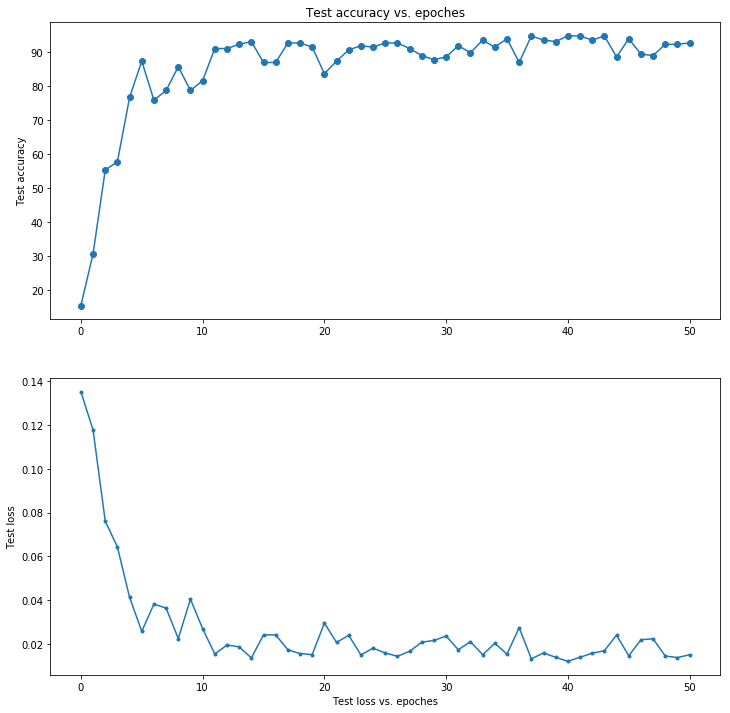

In [5]:
import matplotlib.pyplot as plt
x1 = range(0, total_epoch)
x2 = range(0, total_epoch)
y1 = Accuracy_list
y2 = Loss_list
plt.figure(figsize=(12,12))
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()

In [6]:
from PIL import Image

predict_transform = PredictionTransform([input_size, input_size], np.array([127, 127, 127]), 128.0)

def image_loader(image_name):
    image = Image.open(image_name)    #.convert('RGB')
    image = predict_transform(image).unsqueeze(0)
    return image.cuda()

def forward(image_name):
    inp = image_loader(image_name)
    model.eval()
    with torch.no_grad():
        out = model(inp).cpu()
    print(out)


In [7]:
forward("./valdir/greenlights/000311_3.jpg")

tensor([[ 2.7026,  0.1063,  4.9877, -2.8125, -3.9955, -5.4444, -1.8699]])


In [8]:
forward("valdir/sf6/000517_1.jpg")

tensor([[-7.7935, -1.6562, -1.4321,  0.3489, -1.9277, -1.7680, 12.8210]])
